# Creating the Perfect Bracket

There's nothing quite like the most riveting basketball event of the year: NCAA March Madness. The 64-team tournament consists of 4 regions, each with 16 teams ranked independently of the other regions according to their regular season performance. Each team attempts to win 6 successive games in order to emerge victorious as the NCAA national champion.

Perhaps what contributes most to the intrigue of March Madness is filling out a March Madness bracket. "The American Gaming Association estimated in 2019 that 40 million Americans filled out a combined 149 million brackets for a collective wager of \$4.6 billion." It's important to note that even a single bet can be quite lucrative, particularly when an upset occurs (when a lower-ranking underdog beats a higher-ranking favorite). For example, the first-ever upset of a #1 seed by a #16 seed occurred in the 2019 NCAA tournament. In that game "a \$100 bet paid out \$2,500", which translates to American betting odds of +2500!

<br>
*All quotations were cited from the following article: https://www.gobankingrates.com/money/business/money-behind-march-madness-ncaa-basketball-tournament/*

### Problem Structure

The purpose of this personal project is to perform supervised classification on March Madness data to more accurately predict the outcome of an NCAA tournament games--particularly the occurrence of upsets. This would allow for an increased possibility of yielding the kinds of profits mentioned above by filling out more accurate brackets relative to other participants.

# Data Fetching

### Perceived Predictors

Naturally, it will be vitally important to scrape available data that is pertinent to deciding the outcome of an NCAA March Madness game between any two given teams. To successfully do so, we must break down what are generally the most influential elements of a basketball team's success.

<br>Overall team performance during the regular season is generally a good indicator of how a team will perform in March Madness. This would be captured by statistics, both basic and advanced, such as the following:
**<br>Season Record (%)
<br>Conference Record (%); could be important given that the tournament is split into regions
<br>Regular Season Record vs. Tourney Opponent (%); set to theoretical discrete probability of 50% if no such matchups exist 
<br>Strength of Schedule (SOS); measures the difficulty of the teams played (higher number = greater difficulty)
<br>Top 25 Ranking (boolean); considered a consensus top-tier team
<br>Shots Made per Game (FG, 3P, FT)
<br>Point Differential per Game; measures how dominant/unsuccessful you are at outscoring your opponent on average
<br>Misc. Team Stats per Game (Rebounds, Assists, Blocks, etc.)
**

<br>However, March Madness is well-known for its Cinderalla stories--instances where average or underachieving regular season teams make big, unexpected runs in the tournament. Because of this, **it would likely be beneficial to also have team performance during the tournament as an indicator. The difficulty here will be transforming the data--which would be virtually the same categories as the data scraped for the regular season--in such a way that data leakage is avoided.**

<br>It's important to note that in the NCAA, more so than the NBA, experienced coaches can have just as much of an impact on a game's outcome as the players themselves. Hence, it's reasonable to assume that the following statistics could also be solid indicators:
**<br>Coach March Madness Appearances
<br>Coach Sweet Sixteen Appearances
<br>Coach Final Four Appearances
<br>Coach Championships Won
**

<br>And last but certainly not least, we need the data for the structure of the tournaments themselves:
**<br>Favorite Seed
<br>Underdog Seed
<br>Round Number (1-6)
<br>Game Outcome (boolean); did the underdog upset the favorite?
**

## Examples

In [1]:
from data_fetch import get_team_data, get_rankings_data, get_coach_data

### Team Regular Season Stats

In [2]:
get_team_data(url="https://www.sports-reference.com/cbb/seasons/1993-school-stats.html",
              attrs={'id': 'basic_school_stats'}).head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,409,584,.700,NaN,965,285,178,109,385,546
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,320,493,.649,NaN,795,316,163,47,352,573
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,456,650,.702,NaN,1273,501,246,135,498,650
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,541,767,.705,NaN,1049,393,194,42,556,567
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,458,702,.652,NaN,1117,337,185,120,487,539


In [3]:
get_team_data(url="https://www.sports-reference.com/cbb/seasons/1993-advanced-school-stats.html", 
              attrs={'id': 'adv_school_stats'}).head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,.279,.500,49.9,44.3,NaN,9.6,.458,17.4,NaN,.263
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,.277,.517,51.1,54.5,NaN,5.5,.488,18.4,NaN,.241
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,.270,.527,52.2,56.4,NaN,9.6,.494,17.8,NaN,.228
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,.203,.557,51.3,46.1,NaN,2.8,.518,20.7,NaN,.305
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,.299,.541,51.7,43.1,NaN,8.9,.513,19.4,NaN,.271


### Team Rankings

In [4]:
get_rankings_data(url="https://www.sports-reference.com/cbb/seasons/1993-ratings.html").head()

,Team,Top_25
2,North Carolina,1
3,Kentucky,1
4,Duke,1
5,Indiana,1
6,Cincinnati,1


### Coach Tournament Performance

In [5]:
get_coach_data(url='https://www.sports-reference.com/cbb/seasons/1993-coaches.html').head()

,Coach_Team,MM,S16,F4,Champs
2,Air Force,,,,
3,Akron,,,,
4,Alabama,,,,
5,Alabama-Birmingham,11,5,2,
6,Alabama State,,,,


### Tournament Game Data

In [6]:
get_team_data(url=("https://apps.washingtonpost.com/sports/search/?pri_school_id=&pri_conference=&pri_coach"
                   "=&pri_seed_from=1&pri_seed_to=16&pri_power_conference=&pri_bid_type=&opp_school_id"
                   "=&opp_conference=&opp_coach=&opp_seed_from=1&opp_seed_to=16&opp_power_conference=&opp_bid_type"
                   "=&game_type=7&from=1993&to=1993&submit="), 
              attrs={'class': 'search-results'}, header=0).head()

,Year,Round,Seed,Team,Score,Seed.1,Team.1,Score.1
0,1993,National ChampionshipNational Championship,1,Michigan Michigan,71,1,North Carolina North Carolina,77
1,1993,Final FourFinal Four,1,North Carolina North Carolina,78,2,Kansas Kansas,68
2,1993,Final FourFinal Four,1,Kentucky Kentucky,78,1,Michigan Michigan,81
3,1993,Elite EightElite Eight,1,North Carolina North Carolina,75,2,Cincinnati Cincinnati,68
4,1993,Elite EightElite Eight,1,Michigan Michigan,77,7,Temple Temple,72


# Data Cleaning & Feature Engineering

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_clean import clean_basic_stats, clean_adv_stats, clean_coach_stats, reclean_all_season_stats, clean_tourney_data
from data_merge import merge_clean_team_stats, merge_clean_rankings, merge_clean_coaches, merge_clean_tourney_games

## Data Pipeline

In [8]:
# all_mm_data_df = pd.DataFrame()

# for year in range(1993, 2020):    
#     """Team Regular Season Stats"""
#     # Fetch & clean basic regular season stats
#     season_basic_df = get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/{year}-school-stats.html",
#                                     attrs={'id': 'basic_school_stats'})
#     clean_season_basic_df = clean_basic_stats(season_basic_df)
    
#     # Fetch & clean advanced regular season stats
#     season_adv_df = get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/{year}-advanced-school-stats.html", 
#                                   attrs={'id': 'adv_school_stats'})
#     clean_season_adv_df = clean_adv_stats(season_adv_df)

#     # Merge all cleaned regular season stats
#     team_season_stats_df = merge_clean_team_stats(clean_season_basic_df, clean_season_adv_df)
    
    
#     """Team Rankings"""
#     # Fetch team rankings data (already cleaned)
#     rankings_df = get_rankings_data(url=f"https://www.sports-reference.com/cbb/seasons/{year}-ratings.html")

#     # Merge rankings data to all team stats
#     team_stats_rankings_df = merge_clean_rankings(team_season_stats_df, rankings_df)   

    
#     """Coach Tournament Performance"""
#     # Fetch & clean coach performance data
#     coaches_df = get_coach_data(url=f"https://www.sports-reference.com/cbb/seasons/{year}-coaches.html")
#     clean_coaches_df = clean_coach_stats(coaches_df)
    
#     # Merge coach data to all regular season data
#     all_season_stats_df = merge_clean_coaches(team_stats_rankings_df, clean_coaches_df)
 

#     """Tournament Game Data"""
#     # Reclean all team names & season stats (pre-tourney merge)
#     clean_all_season_stats_df = reclean_all_season_stats(all_season_stats_df, clean_season_basic_df)
    
#     # Fetch & clean tournament game data
#     mm_games_df = get_team_data(url=("https://apps.washingtonpost.com/sports/search/?pri_school_id=&pri_conference=&pri_coach"
#                                  "=&pri_seed_from=1&pri_seed_to=16&pri_power_conference=&pri_bid_type=&opp_school_id"
#                                  "=&opp_conference=&opp_coach=&opp_seed_from=1&opp_seed_to=16&opp_power_conference"
#                                  f"=&opp_bid_type=&game_type=7&from={year}&to={year}&submit="), 
#                                 attrs={'class': 'search-results'}, header=0)    
#     clean_mm_df = clean_tourney_data(mm_games_df, clean_all_season_stats_df)
        
#     # Merge regular season data to tournament games
#     year_mm_data_df = merge_clean_tourney_games(clean_mm_df, clean_all_season_stats_df)
    
#     all_mm_data_df = pd.concat([all_mm_data_df, year_mm_data_df], ignore_index=True)
    
mm_matchups_df = pd.read_csv('march_madness_data.csv')
mm_matchups_df

,Year,Round,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Underdog_Upset,W-L%_Favorite,SOS_Favorite,FG%_Favorite,...,FG/Game_Underdog,3P/Game_Underdog,FT/Game_Underdog,ORB/Game_Underdog,TRB/Game_Underdog,AST/Game_Underdog,STL/Game_Underdog,BLK/Game_Underdog,TOV/Game_Underdog,PF/Game_Underdog
0,1993,National Championship,1,North Carolina,1,Michigan,0,0.895,11.25,0.506,...,31.4,4.2,14.9,NaN,41.5,16.3,6.8,5.4,15.6,18.6
1,1993,Final Four,1,Kentucky,1,Michigan,1,0.882,9.23,0.480,...,31.4,4.2,14.9,NaN,41.5,16.3,6.8,5.4,15.6,18.6
2,1993,Final Four,1,North Carolina,2,Kansas,0,0.895,11.25,0.506,...,30.8,6.0,16.8,NaN,36.1,19.1,9.1,2.9,14.5,17.6
3,1993,Elite Eight,1,Indiana,2,Kansas,1,0.886,11.09,0.522,...,30.8,6.0,16.8,NaN,36.1,19.1,9.1,2.9,14.5,17.6
4,1993,Elite Eight,1,North Carolina,2,Cincinnati,0,0.895,11.25,0.506,...,28.1,5.0,13.2,NaN,36.0,16.0,10.0,2.6,14.1,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2019,First Round,6,Maryland,11,Belmont,0,0.676,10.09,0.449,...,31.6,10.4,13.4,8.7,38.6,19.5,6.7,3.8,11.4,15.4
1743,2019,First Round,6,Buffalo,11,Arizona State,0,0.889,2.62,0.462,...,26.4,7.1,17.6,11.7,39.7,13.5,6.3,3.2,13.7,19.9
1744,2019,Play-In,11,Belmont,11,Temple,0,0.818,-2.60,0.498,...,26.5,7.5,14.3,9.6,34.4,14.4,8.6,2.2,11.2,17.6
1745,2019,Play-In,16,North Dakota State,16,North Carolina Central,0,0.543,-2.07,0.454,...,25.7,6.5,13.5,11.7,37.2,15.5,6.1,2.7,15.1,17.9


## Handling Missing Values

### Records' null counts

In [9]:
describe_df = mm_matchups_df.describe()
describe_df.loc['nulls'] = mm_matchups_df.isnull().sum()
describe_df = describe_df.transpose()

nulls = describe_df[describe_df['nulls'] > 0]['nulls']
nulls.sort_values(ascending=False)

Pace_Underdog        1072.0
Pace_Favorite        1065.0
ORB%_Favorite         766.0
STL%_Favorite         766.0
ORtg_Favorite         766.0
STL%_Underdog         765.0
ORtg_Underdog         765.0
ORB%_Underdog         764.0
ORB/Game_Underdog     255.0
ORB/Game_Favorite     254.0
PF/Game_Underdog       64.0
PF/Game_Favorite       64.0
TOV/Game_Underdog       3.0
TOV%_Underdog           3.0
TOV/Game_Favorite       1.0
TOV%_Favorite           1.0
Name: nulls, dtype: float64

### What are the distributions for the features we wish to impute?

In [10]:
null_drops = [col for col in nulls.index if 'TOV' not in col]
null_fills = list(set(nulls.index) - set(null_drops))

mm_matchups_df.drop(null_drops, axis=1, inplace=True)

nulls_rows = mm_matchups_df[mm_matchups_df.isnull().any(axis=1)]
nulls_rows_feats = nulls_rows[['Year'] + null_fills]
nulls_rows_feats

,Year,TOV/Game_Favorite,TOV%_Underdog,TOV/Game_Underdog,TOV%_Favorite
15,1993,15.6,NaN,NaN,17.4
16,1993,12.0,NaN,NaN,15.9
42,1993,NaN,16.6,17.8,NaN
470,2000,15.8,NaN,NaN,17.8


In [11]:
null_years = sorted(list(set(nulls_rows_feats['Year'])))

1993 feature distributions
2000 feature distributions


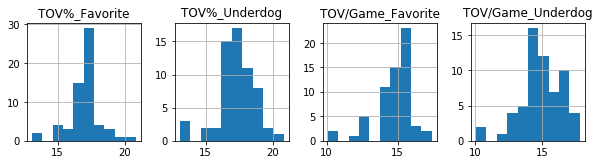

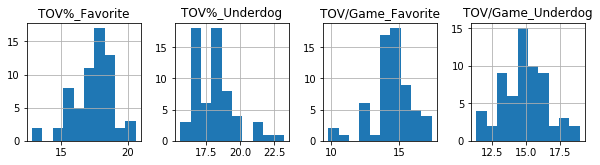

In [12]:
for year in null_years:
    print(f"{year} feature distributions")
    year_df = mm_matchups_df[mm_matchups_df['Year'] == year]
    year_df[null_fills].hist(figsize=(10, 5), layout=(len(null_years), len(null_fills)))

### Impute feature nulls by season

In [13]:
col_year_means = mm_matchups_df[nulls_rows_feats.columns].groupby('Year').mean()
col_year_means.loc[null_years]

,TOV/Game_Favorite,TOV%_Underdog,TOV/Game_Underdog,TOV%_Favorite
Year,,,,
1993,14.787097,17.281967,14.909836,17.066129
2000,14.520635,18.106452,14.916129,17.384127


In [14]:
for year in null_years:
    for col in null_fills:
        col_fill_rows = nulls_rows_feats[nulls_rows_feats['Year'] == year].index
        col_year_mean = np.round(col_year_means.loc[year, col], 1)
        
        mm_matchups_df.loc[col_fill_rows, col] = mm_matchups_df.loc[col_fill_rows, col].fillna(col_year_mean)
        
mm_matchups_df.loc[nulls_rows_feats.index, null_fills]

,TOV/Game_Favorite,TOV%_Underdog,TOV/Game_Underdog,TOV%_Favorite
15,15.6,17.3,14.9,17.4
16,12.0,17.3,14.9,15.9
42,14.8,16.6,17.8,17.1
470,15.8,18.1,14.9,17.8


# Exploratory Data Analysis (EDA)

As any good data scientist should do, there are a few questions I hope to address in my EDA

## What is a bracket's accuracy given random guessing in favor of the majority class (base rate: favorite beats underdog)?

In [15]:
years_ma = 2

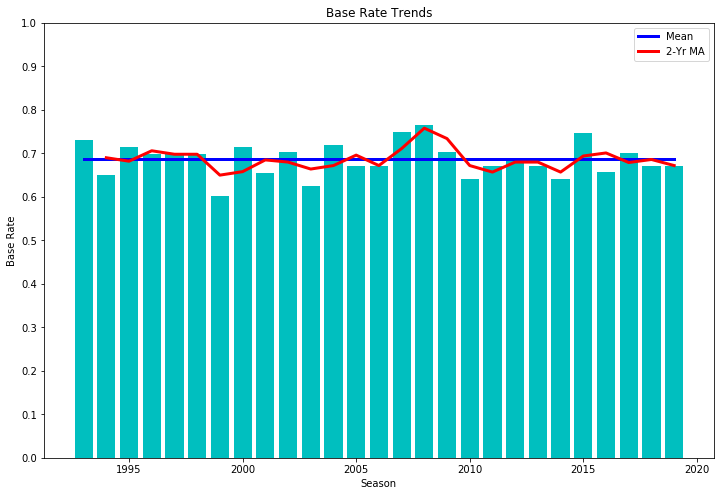

In [16]:
yearly_outcomes = mm_matchups_df.groupby(['Year', 'Underdog_Upset']).agg({'Round': 'count'})
yearly_games = mm_matchups_df.groupby('Year').agg({'Round': 'count'})
yearly_outcomes = pd.merge(yearly_outcomes, yearly_games, left_index=True, right_index=True)

yearly_fave_wins = yearly_outcomes.loc[(slice(None), 0), :]
yearly_base_rate = np.round(yearly_fave_wins['Round_x'] / yearly_fave_wins['Round_y'], 3)
yearly_base_rate.index = yearly_base_rate.index.get_level_values(0)

base_rate_ma = np.round(yearly_base_rate.rolling(years_ma).mean(), 3)
mean_base_rate = np.round(yearly_base_rate.mean(), 3)

plt.figure(figsize=(12, 8))

plt.plot(yearly_base_rate.index, [mean_base_rate] * len(yearly_base_rate), color='b', linewidth=3, label='Mean')
plt.plot(yearly_base_rate.index, base_rate_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_base_rate.index, yearly_base_rate, color='c')

plt.title('Base Rate Trends')
plt.xlabel('Season')
plt.ylabel('Base Rate')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='upper right')

In [17]:
normed_yearly_base_rate = np.abs((yearly_base_rate - mean_base_rate) / yearly_base_rate.std())
normed_std_base_rate = np.round(normed_yearly_base_rate.mean(), 4)

print(f"Mean Base Rate: {mean_base_rate}")
print(f"Normalized Standard Deviation: {normed_std_base_rate}")

Mean Base Rate: 0.686
Normalized Standard Deviation: 0.8013


## How often do upsets occur in a given year's March Madness? 

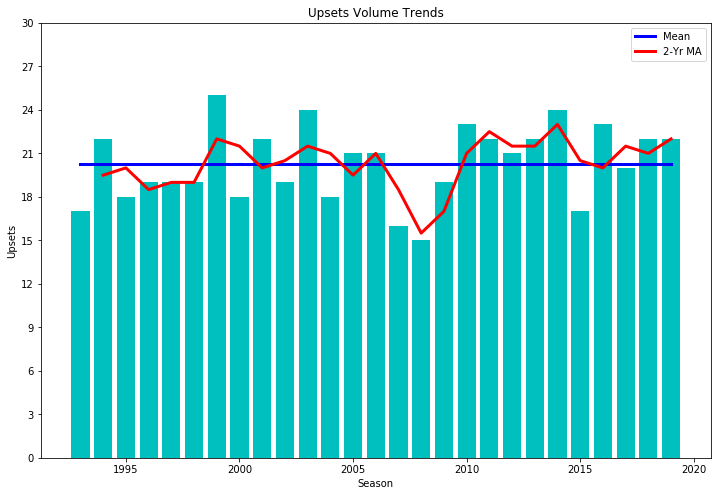

In [18]:
yearly_upsets = mm_matchups_df.groupby('Year').agg({'Underdog_Upset': 'sum'})
upsets_ma = np.round(yearly_upsets.rolling(years_ma).mean(), 1)
mean_upsets = np.round(yearly_upsets['Underdog_Upset'].mean(), 1)

plt.figure(figsize=(12, 8))

plt.plot(yearly_upsets.index, [mean_upsets] * len(yearly_upsets), color='b', linewidth=3, label='Mean')
plt.plot(yearly_upsets.index, upsets_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_upsets.index, yearly_upsets['Underdog_Upset'], color='c')

plt.title('Upsets Volume Trends')
plt.xlabel('Season')
plt.ylabel('Upsets')
plt.yticks(np.arange(0, 33, 3))
plt.legend(loc='upper right')

In [19]:
normed_yearly_upsets = np.abs((yearly_upsets - mean_upsets) / yearly_upsets.std())
normed_std_upsets = np.round(normed_yearly_upsets['Underdog_Upset'].mean(), 4)

print(f"Mean Upsets: {mean_upsets}")
print(f"Normalized Standard Deviation: {normed_std_upsets}")

Mean Upsets: 20.3
Normalized Standard Deviation: 0.8507


## What is the distribution of upsets across each tournament round?

In [20]:
sorted_pairs = []

for index, data in mm_matchups_df.iterrows():
    sorted_pair = tuple(sorted([data['Seed_Favorite'], data['Seed_Underdog']]))
    sorted_pairs.append(sorted_pair)

seed_pairs = pd.DataFrame(data = {
    'Pairs': sorted_pairs,
    'Round': mm_matchups_df['Round'],
    'Underdog_Upset': mm_matchups_df['Underdog_Upset']
})

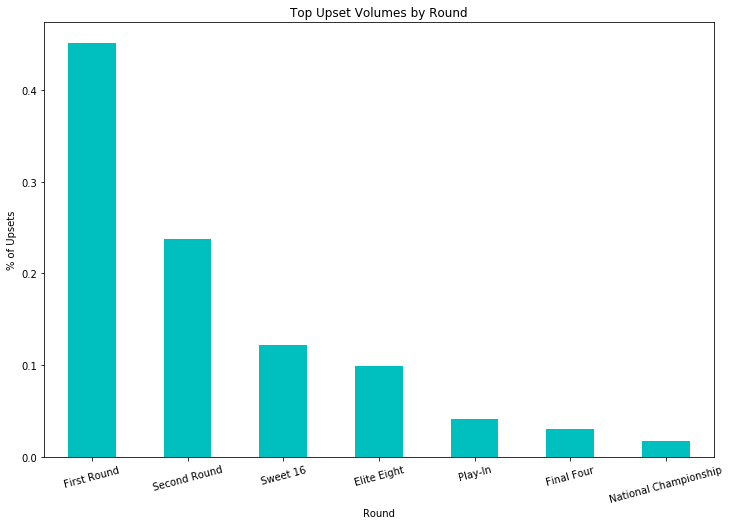

In [21]:
upset_pairs = seed_pairs[seed_pairs['Underdog_Upset'] == 1]
upset_rounds_freq = np.round(upset_pairs['Round'].value_counts(normalize=True), 3)

plt.title('Top Upset Volumes by Round')
plt.xlabel('Round')
plt.ylabel('% of Upsets')

upset_rounds_freq.plot(figsize=(12, 8), kind='bar', color='c', rot=15)

## Which seeding combinations are the most likely to produce upsets?

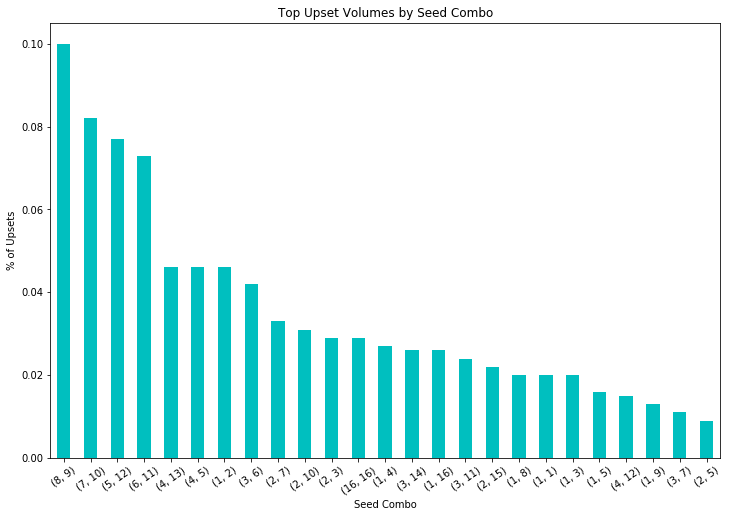

In [22]:
upset_pairs_freq = np.round(upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)

plt.title('Top Upset Volumes by Seed Combo')
plt.xlabel('Seed Combo')
plt.ylabel('% of Upsets')

upset_pairs_freq.plot(figsize=(12, 8), kind='bar', color='c', rot=35)

# Feature Engineering (cont'd)

# Feature Selection

### What is the correlation between features?

### What features have the greatest predictive power?

# Model Selection

# Model Evaluation

# Conclusions